In [1]:
import torch
from torch import nn, optim
from jcopdl.callback import Callback, set_config

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

# Dataset & dataloader

In [2]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [51]:
bs = 128
crop_size = 128

train_transform = transforms.Compose([
    transforms.RandomRotation(90),
    transforms.RandomRotation(45),
    transforms.ColorJitter(brightness=0.3),
    transforms.RandomAffine(0, translate=(0.3, 0.3)),
    transforms.RandomResizedCrop(crop_size, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    transforms.Resize(140),
    transforms.CenterCrop(crop_size),
    transforms.ToTensor()
])

train_set = datasets.ImageFolder("data/train/", transform=train_transform)
trainloader = DataLoader(train_set, batch_size=bs, shuffle=True, num_workers=4)

test_set = datasets.ImageFolder("data/test/", transform=test_transform)
testloader = DataLoader(test_set, batch_size=bs, shuffle=True)

In [52]:
feature, target = next(iter(trainloader))
feature.shape

torch.Size([128, 3, 128, 128])

In [53]:
label = train_set.classes
label

['paper', 'rock', 'scissors']

# Arsitektur & Config 

In [34]:
from jcopdl.layers import conv_block, linear_block

In [54]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            conv_block(3, 8),
            conv_block(8, 16), 
            conv_block(16, 32),
            conv_block(32, 64),
            conv_block(64, 128), 
            nn.Flatten()
        )
        
        self.fc = nn.Sequential(
            linear_block(2048, 1024, dropout=0.25),
            linear_block(1024, 512, dropout=0.25),
            linear_block(512, 256, dropout=0.25),
            linear_block(256, 3, activation="lsoftmax")
        )
        
    def forward(self, x):
        x = self.conv(x)
        x = self.fc(x)
        return x

config = set_config({
    "batch_size": bs,
    "crop_size": crop_size
})

# Training Preparation -> MCOC

In [55]:
model = CNN().to(device)
criterion = nn.NLLLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001)
callback = Callback(model, config, outdir="model/model1")

# Training

In [56]:
from tqdm.auto import tqdm

def loop_fn(mode, dataset, dataloader, model, criterion, optimizer, device):
    if mode == "train":
        model.train()
    elif mode == "test":
        model.eval()
    cost = correct = 0
    for feature, target in tqdm(dataloader, desc=mode.title()):
        feature, target = feature.to(device), target.to(device)
        output = model(feature)
        loss = criterion(output, target)
        
        if mode == "train":
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        
        cost += loss.item() * feature.shape[0]
        correct += (output.argmax(1) == target).sum().item()
    cost = cost / len(dataset)
    acc = correct / len(dataset)
    return cost, acc



Epoch     1
Train_cost  = 1.0996 | Test_cost  = 1.0979 | Train_score = 0.3330 | Test_score = 0.3417 |




Epoch     2
Train_cost  = 1.0957 | Test_cost  = 1.0879 | Train_score = 0.3466 | Test_score = 0.3121 |
==> EarlyStop patience =  1 | Best test_score: 0.3417




Epoch     3
Train_cost  = 1.0627 | Test_cost  = 1.0398 | Train_score = 0.4213 | Test_score = 0.4556 |




Epoch     4
Train_cost  = 1.0326 | Test_cost  = 0.9604 | Train_score = 0.4532 | Test_score = 0.5513 |




Epoch     5
Train_cost  = 0.9758 | Test_cost  = 1.0250 | Train_score = 0.5080 | Test_score = 0.4579 |
==> EarlyStop patience =  1 | Best test_score: 0.5513




Epoch     6
Train_cost  = 0.9075 | Test_cost  = 0.7989 | Train_score = 0.5496 | Test_score = 0.6446 |




Epoch     7
Train_cost  = 0.7682 | Test_cost  = 1.2551 | Train_score = 0.6425 | Test_score = 0.4237 |
==> EarlyStop patience =  1 | Best test_score: 0.6446




Epoch     8
Train_cost  = 0.6485 | Test_cost  = 0.5730 | Train_score = 0.7212 | Test_score = 0.7426 |




Epoch     9
Train_cost  = 0.5308 | Test_cost  = 0.6049 | Train_score = 0.7879 | Test_score = 0.7768 |




Epoch    10
Train_cost  = 0.4920 | Test_cost  = 0.4854 | Train_score = 0.7976 | Test_score = 0.7950 |




Epoch    11
Train_cost  = 0.4648 | Test_cost  = 0.5902 | Train_score = 0.8335 | Test_score = 0.7654 |
==> EarlyStop patience =  1 | Best test_score: 0.7950




Epoch    12
Train_cost  = 0.4892 | Test_cost  = 0.4901 | Train_score = 0.7856 | Test_score = 0.8109 |




Epoch    13
Train_cost  = 0.4291 | Test_cost  = 0.3894 | Train_score = 0.8312 | Test_score = 0.8770 |




Epoch    14
Train_cost  = 0.3840 | Test_cost  = 0.4267 | Train_score = 0.8586 | Test_score = 0.8724 |
==> EarlyStop patience =  1 | Best test_score: 0.8770




Epoch    15
Train_cost  = 0.3308 | Test_cost  = 0.4827 | Train_score = 0.8831 | Test_score = 0.8588 |
==> EarlyStop patience =  2 | Best test_score: 0.8770




Epoch    16
Train_cost  = 0.3231 | Test_cost  = 0.3506 | Train_score = 0.8894 | Test_score = 0.8998 |




Epoch    17
Train_cost  = 0.5257 | Test_cost  = 0.5353 | Train_score = 0.7811 | Test_score = 0.6902 |
==> EarlyStop patience =  1 | Best test_score: 0.8998




Epoch    18
Train_cost  = 0.4711 | Test_cost  = 0.3449 | Train_score = 0.7976 | Test_score = 0.8929 |
==> EarlyStop patience =  2 | Best test_score: 0.8998




Epoch    19
Train_cost  = 0.3818 | Test_cost  = 0.3082 | Train_score = 0.8734 | Test_score = 0.9089 |




Epoch    20
Train_cost  = 0.3183 | Test_cost  = 0.2683 | Train_score = 0.8945 | Test_score = 0.9248 |


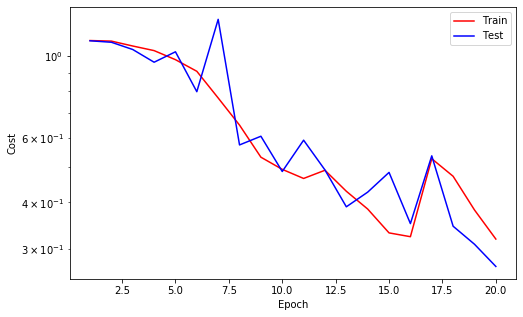

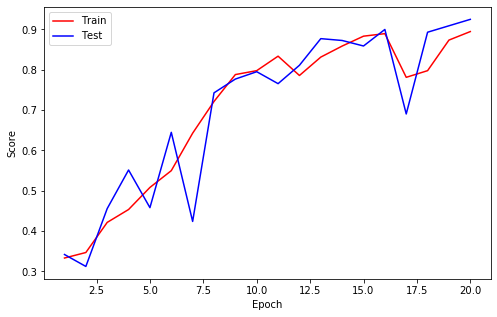



Epoch    21
Train_cost  = 0.3252 | Test_cost  = 0.4852 | Train_score = 0.8888 | Test_score = 0.8314 |
==> EarlyStop patience =  1 | Best test_score: 0.9248




Epoch    22
Train_cost  = 0.3315 | Test_cost  = 0.2525 | Train_score = 0.8894 | Test_score = 0.9203 |
==> EarlyStop patience =  2 | Best test_score: 0.9248




Epoch    23
Train_cost  = 0.2930 | Test_cost  = 0.2234 | Train_score = 0.9139 | Test_score = 0.9294 |




Epoch    24
Train_cost  = 0.2138 | Test_cost  = 0.3144 | Train_score = 0.9379 | Test_score = 0.9134 |
==> EarlyStop patience =  1 | Best test_score: 0.9294




Epoch    25
Train_cost  = 0.2572 | Test_cost  = 0.2515 | Train_score = 0.9133 | Test_score = 0.9157 |
==> EarlyStop patience =  2 | Best test_score: 0.9294




Epoch    26
Train_cost  = 0.1957 | Test_cost  = 0.1938 | Train_score = 0.9424 | Test_score = 0.9590 |




Epoch    27
Train_cost  = 0.2026 | Test_cost  = 0.1775 | Train_score = 0.9396 | Test_score = 0.9522 |
==> EarlyStop patience =  1 | Best test_score: 0.9590




Epoch    28
Train_cost  = 0.1728 | Test_cost  = 0.1511 | Train_score = 0.9464 | Test_score = 0.9499 |
==> EarlyStop patience =  2 | Best test_score: 0.9590




Epoch    29
Train_cost  = 0.2024 | Test_cost  = 0.1994 | Train_score = 0.9436 | Test_score = 0.9476 |
==> EarlyStop patience =  3 | Best test_score: 0.9590




Epoch    30
Train_cost  = 0.2147 | Test_cost  = 0.1393 | Train_score = 0.9304 | Test_score = 0.9636 |




Epoch    31
Train_cost  = 0.2141 | Test_cost  = 0.2228 | Train_score = 0.9339 | Test_score = 0.9157 |
==> EarlyStop patience =  1 | Best test_score: 0.9636




Epoch    32
Train_cost  = 0.2252 | Test_cost  = 0.1542 | Train_score = 0.9265 | Test_score = 0.9476 |
==> EarlyStop patience =  2 | Best test_score: 0.9636




Epoch    33
Train_cost  = 0.1802 | Test_cost  = 0.2113 | Train_score = 0.9510 | Test_score = 0.9271 |
==> EarlyStop patience =  3 | Best test_score: 0.9636




Epoch    34
Train_cost  = 0.1935 | Test_cost  = 0.2095 | Train_score = 0.9396 | Test_score = 0.9339 |
==> EarlyStop patience =  4 | Best test_score: 0.9636




Epoch    35
Train_cost  = 0.2216 | Test_cost  = 0.2472 | Train_score = 0.9247 | Test_score = 0.9180 |
==> EarlyStop patience =  5 | Best test_score: 0.9636
==> Execute Early Stopping at epoch: 35 | Best test_score: 0.9636
==> Best model is saved at model/model1


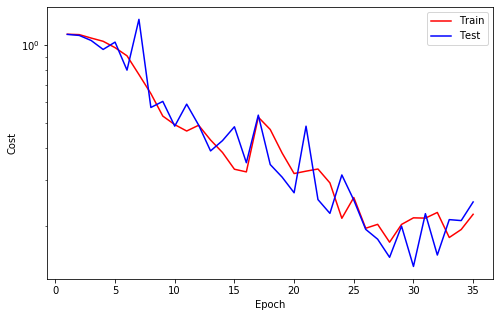

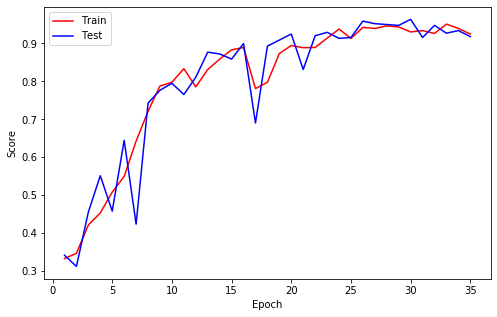

In [57]:
while True:
    train_cost, train_score = loop_fn("train", train_set, trainloader, model, criterion, optimizer, device)
    with torch.no_grad():
        test_cost, test_score = loop_fn("test", test_set, testloader, model, criterion, optimizer, device)
    
    # Logging
    callback.log(train_cost, test_cost, train_score, test_score)

    # Checkpoint
    callback.save_checkpoint()
        
    # Runtime Plotting
    callback.cost_runtime_plotting()
    callback.score_runtime_plotting()
    
    # Early Stopping
    if callback.early_stopping(model, monitor="test_score"):
        callback.plot_cost()
        callback.plot_score()
        break

In [58]:
feature, target = next(iter(testloader))
feature, target = feature.to(device), target.to(device)

In [59]:
with torch.no_grad():
    model.eval()
    output = model(feature)
    preds = output.argmax(1)
preds

tensor([1, 2, 0, 2, 0, 2, 0, 1, 2, 1, 2, 1, 1, 1, 2, 1, 2, 2, 1, 2, 2, 1, 0, 1,
        1, 2, 2, 0, 1, 2, 0, 2, 1, 0, 2, 2, 1, 0, 2, 1, 0, 1, 2, 2, 1, 2, 2, 0,
        1, 2, 2, 1, 0, 1, 2, 1, 1, 0, 1, 2, 2, 1, 2, 0, 0, 0, 2, 2, 1, 2, 2, 0,
        1, 2, 0, 0, 0, 2, 0, 1, 1, 0, 0, 2, 2, 2, 0, 1, 1, 2, 2, 1, 0, 2, 2, 2,
        1, 1, 2, 0, 0, 2, 0, 0, 0, 0, 2, 2, 1, 2, 0, 1, 2, 2, 1, 2, 2, 0, 0, 0,
        1, 0, 2, 0, 1, 0, 2, 0], device='cuda:0')

In [60]:
import matplotlib.pyplot as plt

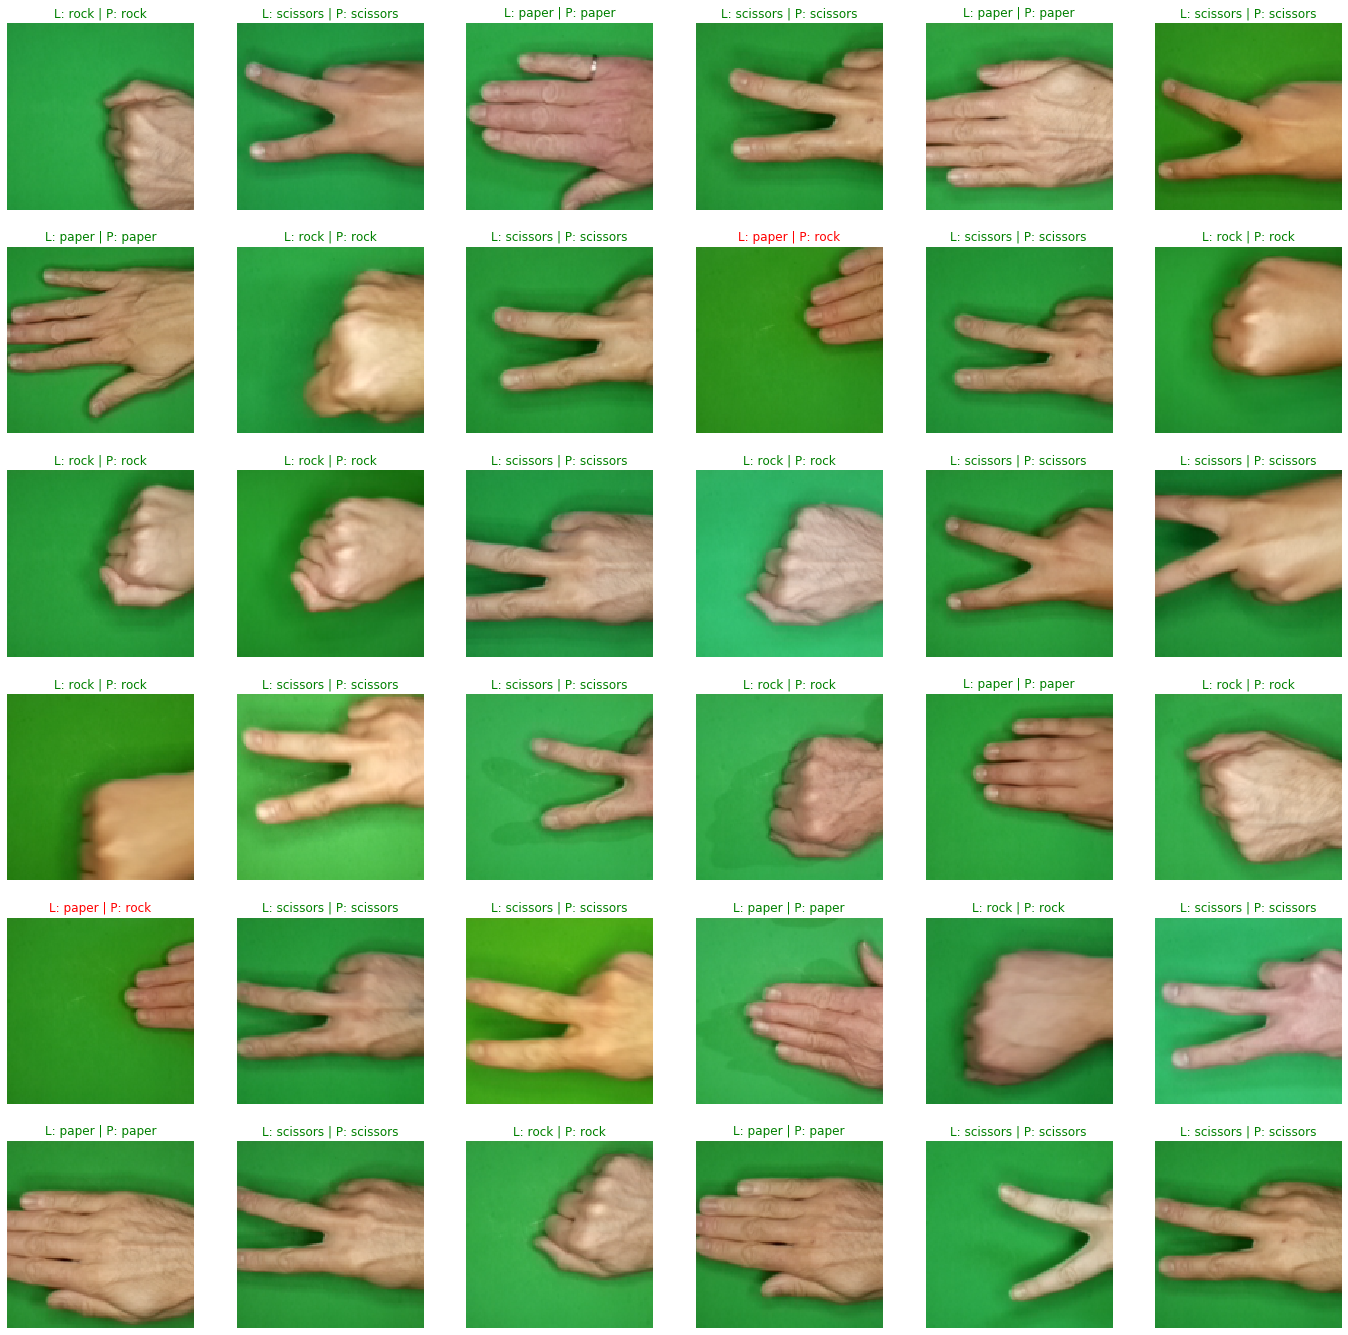

In [61]:
fig, axes = plt.subplots(6, 6, figsize=(24, 24))
for image, label, pred, ax in zip(feature, target, preds, axes.flatten()):
    ax.imshow(image.permute(1, 2, 0).cpu())
    font = {"color": 'r'} if label != pred else {"color": 'g'}        
    label, pred = train_set.classes[label.item()], train_set.classes[pred.item()]
    ax.set_title(f"L: {label} | P: {pred}", fontdict=font);
    ax.axis('off');

## Sample data predict

In [62]:
sample_set = datasets.ImageFolder("Sample/", transform=test_transform)
sampleloader = DataLoader(sample_set, batch_size=bs, shuffle=True)

feature, target = next(iter(sampleloader))
feature.shape

torch.Size([24, 3, 128, 128])

In [63]:
sample_set.classes

['paper', 'rock', 'scissors']

In [64]:
with torch.no_grad():
    model.eval()
    output = model(feature.to(device))
    preds = output.argmax(1)
preds

tensor([2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 2, 0, 0, 0, 1, 0],
       device='cuda:0')

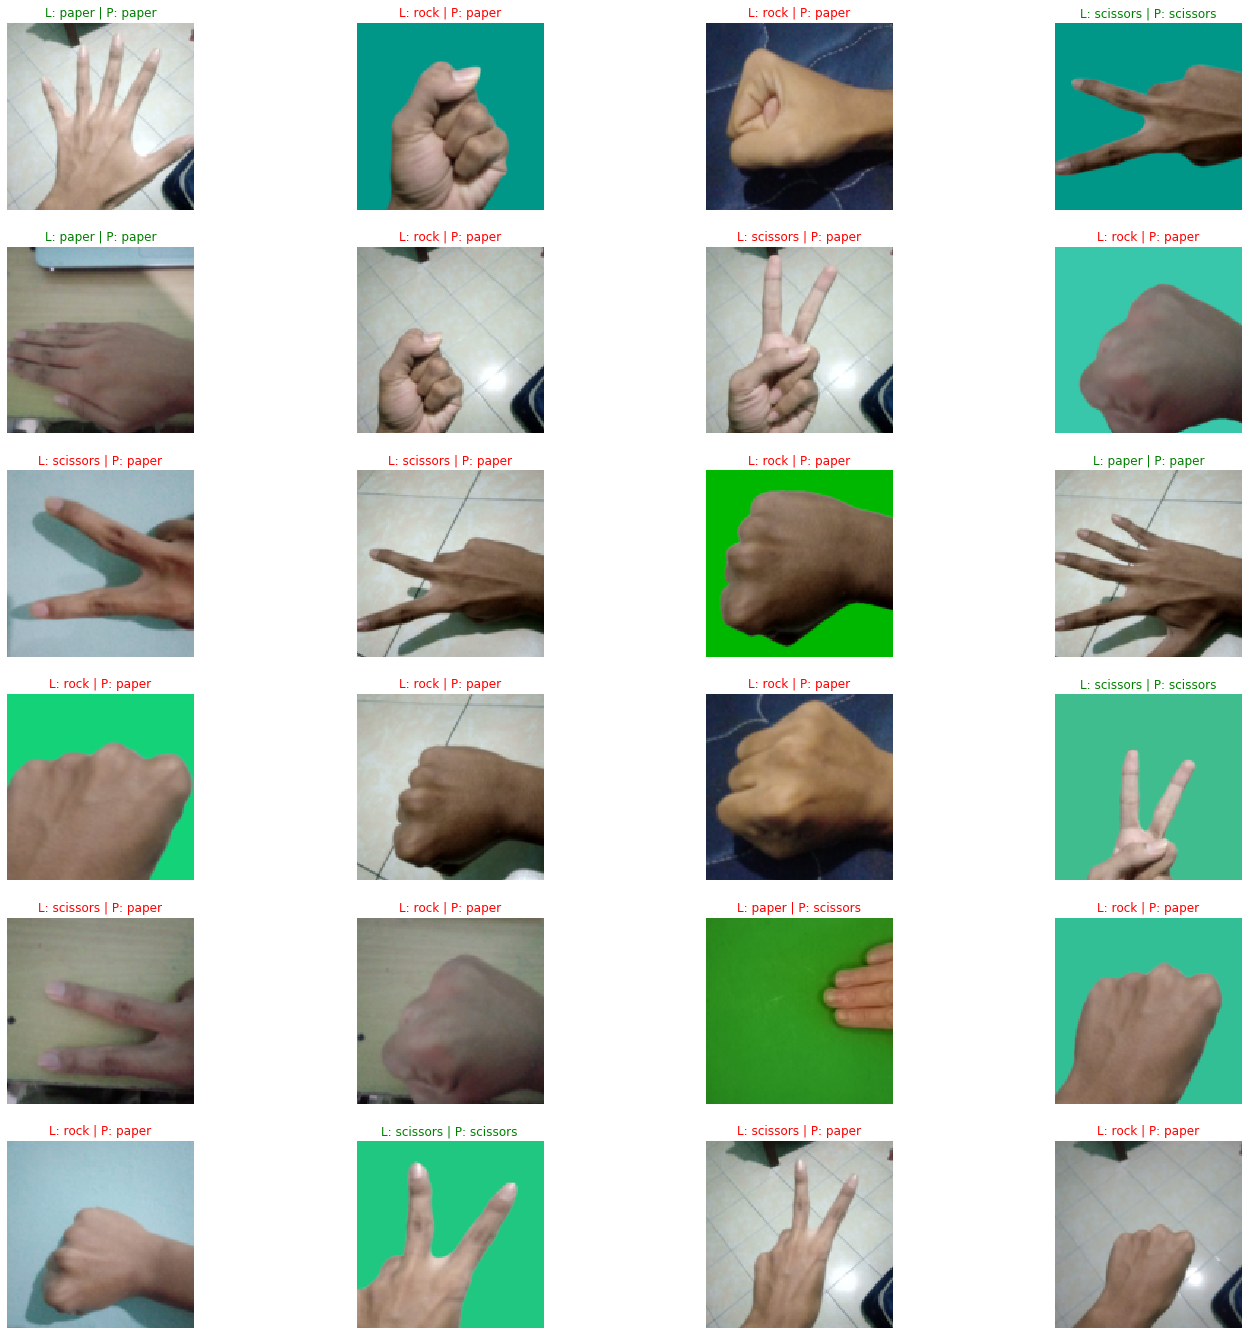

In [50]:
fig, axes = plt.subplots(6, 4, figsize=(24, 24))
for image, label, pred, ax in zip(feature.cpu(), target.cpu(), preds.cpu(), axes.flatten()):
    ax.imshow(image.permute(1, 2, 0).cpu())
    font = {"color": 'r'} if label != pred else {"color": 'g'}        
    label, pred = sample_set.classes[label.item()], sample_set.classes[pred.item()]
    ax.set_title(f"L: {label} | P: {pred}", fontdict=font);
    ax.axis('off');

Untuk Kasus Seperti diatas ternyata masih overfit